In [24]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

In [26]:
def im2col(input_matrix, kernel_height, kernel_width, stride, padding, dilation):
    num_inputs, in_channels, input_height, input_width = input_matrix.shape

    output_height = (input_height + 2 * padding[0] - dilation[0] * (kernel_height - 1) - 1) // stride[0] + 1
    output_width = (input_width + 2 * padding[1] - dilation[1] * (kernel_width - 1) - 1) // stride[1] + 1

    padded_input = np.pad(input_matrix, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), mode='constant')

    i0 = np.repeat(np.arange(kernel_height), kernel_width)
    i0 = np.tile(i0, in_channels)
    i1 = stride[0] * np.repeat(np.arange(output_height), output_width)
    j0 = np.tile(np.arange(kernel_width), kernel_height * in_channels)
    j1 = stride[1] * np.tile(np.arange(output_width), output_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(in_channels), kernel_height * kernel_width).reshape(-1, 1)

    cols = padded_input[:, k, i, j]
    cols = cols.transpose(1, 2, 0).reshape(kernel_height * kernel_width * in_channels, -1)
    
    return cols.T

In [28]:
def conv2d(input_matrix, kernel, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    num_inputs, in_channels, input_height, input_width = input_matrix.shape
    out_channels, not_needed, kernel_height, kernel_width = kernel.shape

    output_height = (input_height + 2 * padding[0] - dilation[0] * (kernel_height - 1) - 1) // stride[0] + 1
    output_width = (input_width + 2 * padding[1] - dilation[1] * (kernel_width - 1) - 1) // stride[1] + 1

    col_matrix = im2col(input_matrix, kernel_height, kernel_width, stride, padding, dilation)
    kernel_matrix = kernel.reshape(out_channels, -1)

    output = np.dot(col_matrix, kernel_matrix.T)
    output = output.reshape(num_inputs, output_height, output_width, out_channels).transpose(0, 3, 1, 2)

    return output

Number of output mismatches: 1000 out of 1000 trials


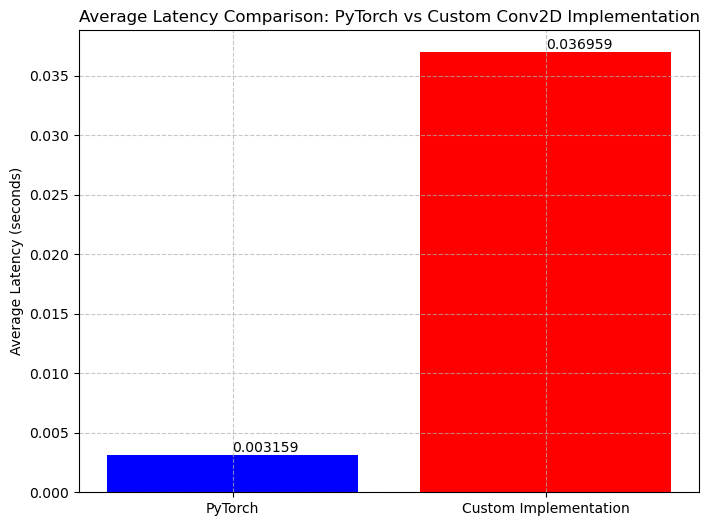

In [30]:
def measure_latency():
    input_matrix = np.random.randn(20, 16, 50, 100).astype(np.float32)
    kernel = np.random.randn(33, 16, 3, 5).astype(np.float32)

    input_tensor = torch.tensor(input_matrix)
    kernel_tensor = torch.tensor(kernel)

    conv2d_layer = nn.Conv2d(in_channels=16, out_channels=33, kernel_size=(3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1), bias=False)
    conv2d_layer.weight = torch.nn.Parameter(kernel_tensor)

    pytorch_times = []
    custom_times = []
    output_comparisons = []

    # Run 1000 latency trials
    for _ in range(1000):
        start_time = time.time()
        with torch.no_grad():
            pytorch_output = conv2d_layer(input_tensor)
        pytorch_times.append(time.time() - start_time)

        start_time = time.time()
        custom_output = conv2d(input_matrix, kernel, stride=(2, 1), padding=(4, 2), dilation=(3, 1))
        custom_times.append(time.time() - start_time)

        custom_output_tensor = torch.tensor(custom_output).float()

        are_outputs_close = torch.allclose(pytorch_output, custom_output_tensor, atol=1e-4)
        output_comparisons.append(are_outputs_close)

    print(f"Number of output mismatches: {output_comparisons.count(False)} out of 1000 trials")

    # Calculate averages
    pytorch_avg = np.mean(pytorch_times)
    custom_avg = np.mean(custom_times)

    return pytorch_avg, custom_avg

def plot_latency_comparison(pytorch_avg, custom_avg):
    plt.figure(figsize=(8, 6))

    # Data for bar chart
    labels = ['PyTorch', 'Custom Implementation']
    averages = [pytorch_avg, custom_avg]

    bars = plt.bar(labels, averages, color=['blue', 'red'])

    # Adding labels and title
    plt.ylabel('Average Latency (seconds)')
    plt.title('Average Latency Comparison: PyTorch vs Custom Conv2D Implementation')

    # Adding value labels on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 6), va='bottom')  # va: vertical alignment

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

def main():
    pytorch_avg, custom_avg = measure_latency()
    plot_latency_comparison(pytorch_avg, custom_avg)

main()